In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
filters = np.load(os.path.join(cluster_dir,'20230202_SC_temporal_filters.npy'))
print(filters.shape)
### get peaks
peaks = np.argmax(filters,axis=-1)
print(peaks.shape)

(501, 4, 500)
(501, 4)


In [4]:
def NormalizeData(data):
    return (data - np.min(data[:250])) / (np.max(data) - np.min(data[:250]))

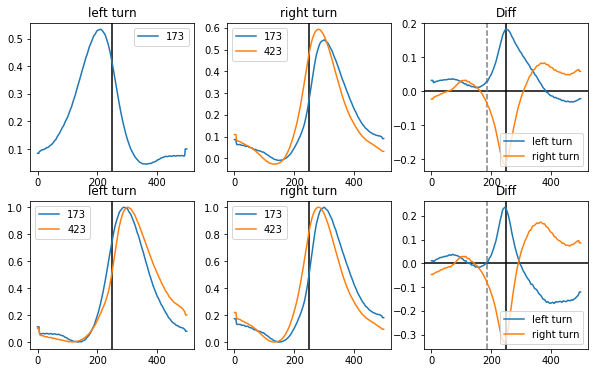

In [247]:
#### NOT NORMALIZED ###

cluster = 173

plt.figure(figsize=(10,6))

plt.subplot(231)
plt.title("left turn")
plt.axvline(250,color='k')
plt.plot(filters[cluster,1],label=cluster)
#plt.plot(filters[cluster+250,1,::-1],label=cluster+250)
plt.legend()

plt.subplot(232)
plt.title("right turn")
plt.axvline(250,color='k')
plt.plot(filters[cluster,2,::-1],label=cluster)
plt.plot(filters[cluster+250,2,::-1],label=cluster+250)
plt.legend()

plt.subplot(233)
plt.title("Diff")
plt.axhline(0,color='k')
plt.axvline(250,color='k')
plt.axvline(185,color='grey',linestyle='--')
plt.plot(filters[cluster,1,::-1]-filters[cluster+250,1,::-1],label='left turn')
plt.plot((filters[cluster,2,::-1]-filters[cluster+250,2,::-1]),label='right turn')
plt.legend()

### NORMALIZED ###
plt.subplot(234)
plt.title("left turn")
plt.axvline(250,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1]),label=cluster)
plt.plot(NormalizeData(filters[cluster+250,1,::-1]),label=cluster+250)
plt.legend()

plt.subplot(235)
plt.title("right turn")
plt.axvline(250,color='k')
plt.plot(NormalizeData(filters[cluster,2,::-1]),label=cluster)
plt.plot(NormalizeData(filters[cluster+250,2,::-1]),label=cluster+250)
plt.legend()

plt.subplot(236)
plt.title("Diff")
plt.axhline(0,color='k')
plt.axvline(250,color='k')
plt.axvline(185,color='grey',linestyle='--')
plt.plot(NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1]),label='left turn')
plt.plot((NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1])),label='right turn')
plt.legend()

In [88]:
derivative_thresh = 0.001


using 0 point


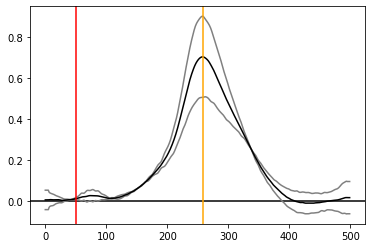

In [133]:
r_thresh = .5
derivative_thresh = 0.001

cluster = 246

a = filters[cluster,1,::-1]-filters[cluster+250,1,::-1]
b = (filters[cluster,2,::-1]-filters[cluster+250,2,::-1])*-1

r,_ = scipy.stats.pearsonr(a,b)

# if r < r_thresh:
#     continue



plt.axhline(0,color='k')
plt.plot(a,color='grey')
plt.plot(b,color='grey')
mean_trace = (a+b)/2
plt.plot(mean_trace,color='k')

peak = np.argmax(mean_trace)
plt.axvline(peak,color='orange')
above_0 = mean_trace>0.01

## if the meantrace does not cross 0 at all before the peak
# use derivative instead
if len(np.where(above_0[:peak][::-1] == False)[0])==0:
    diff = np.diff(mean_trace)
    div_break = np.where(np.diff(mean_trace)[:peak][::-1][10:] < derivative_thresh)[0][0] + 10
    breakpt = div_break
    print('using derivative')
else:
    breakpt_ = np.where(above_0[:peak][::-1] == False)[0][0]
    breakpt = peak-breakpt_
    print('using 0 point')
    
plt.axvline(breakpt,color='r')

In [241]:
500*20

10000

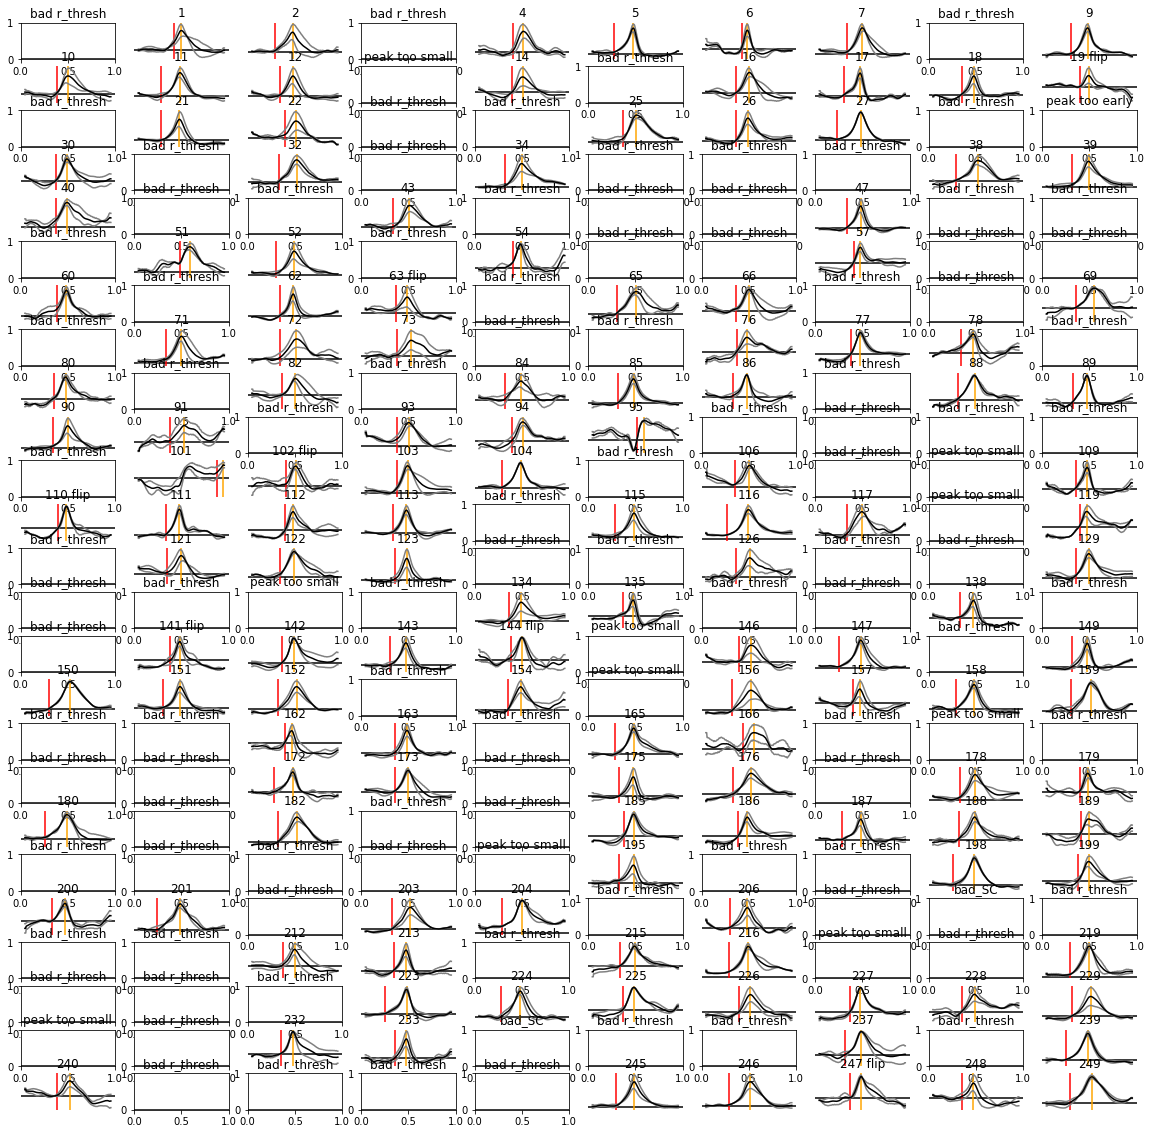

In [4]:
plt.figure(figsize=(20,20))
# use not-normalized
# filter by correlation between two samples
# define sym break by first tp !=0 that is continuous with main hump
bad_SC = [208,234] #234 not bad, but peak diff is at 0
r_thresh = .5
derivative_thresh = 0.001

break_points = []
very_early_clusters = []
very_late_clusters = []
mean_traces = []
for cluster in range(250):
    flip = False
    plt.subplot(25,10,cluster+1)
    plt.axhline(0,color='k')
    
    if cluster in bad_SC:
        plt.title('bad_SC')
        break_points.append(0)
        very_early_clusters.append(0)
        very_late_clusters.append(0)
        mean_traces.append(np.zeros((500)))
        continue

    a = filters[cluster,1,::-1]-filters[cluster+250,1,::-1]
    b = (filters[cluster,2,::-1]-filters[cluster+250,2,::-1])*-1

    r,_ = scipy.stats.pearsonr(a,b)
    
    if r < r_thresh:
        plt.title('bad r_thresh')
        break_points.append(0)
        very_early_clusters.append(0)
        very_late_clusters.append(0)
        mean_traces.append(np.zeros((500)))
        continue
    
    mean_trace = (a+b)/2
    
    ### see if should flip sign for the rare few
    extreme_v = mean_trace[np.argmax(np.abs(mean_trace))]
    if extreme_v < 0:
        a*=-1; b*=-1; mean_trace*=-1
        flip=True
    
    peak = np.argmax(mean_trace)
    
    if peak < 10:
        plt.title('peak too early')
        break_points.append(0)
        very_early_clusters.append(0)
        very_late_clusters.append(0)
        mean_traces.append(np.zeros((500)))
        continue
        
    if np.max(mean_trace) < .1:
        plt.title('peak too small')
        break_points.append(0)
        very_early_clusters.append(0)
        very_late_clusters.append(0)
        mean_traces.append(np.zeros((500)))
        continue
    
    # find where derivative exceeds thresh just before peak 
    break_div = np.where(np.diff(mean_trace)[:peak][::-1][20:] < derivative_thresh)[0][0] + 20
    break_div = peak - break_div
    
    # find where trace exceeds thresh just before peak
    above_0 = mean_trace>0.01
    try:
        break_0 = np.where(above_0[:peak][::-1] == False)[0][0]
        break_0 = peak - break_0
    except IndexError:
        break_0 = 0
    
    # use "latest" of cross 0 and derivative thresh
    break_point = np.max(np.asarray((break_div, break_0)))
    break_points.append(break_point)
    
    plt.axvline(peak,color='orange')
    plt.axvline(break_point,color='r')
    
    plt.plot(a,color='grey')
    plt.plot(b,color='grey')
    plt.plot(mean_trace,color='k')
    
    plt.axis('off')
    if flip is False:
        plt.title(cluster)
    else:
        plt.title(F"{cluster} flip")
        
    ### check for very early
    very_early_clusters.append(np.mean(mean_trace[:100]))
    very_late_clusters.append(np.mean(mean_trace[100:]))
    mean_traces.append(mean_trace)

In [7]:
np.where(np.asarray(very_late_clusters)==0)

(array([  0,   3,   8,  13,  15,  20,  23,  24,  28,  29,  31,  33,  35,
         36,  37,  41,  42,  44,  45,  46,  48,  49,  50,  53,  55,  56,
         58,  59,  61,  64,  67,  68,  70,  74,  75,  79,  81,  83,  87,
         92,  96,  97,  98,  99, 100, 105, 107, 108, 114, 118, 120, 124,
        125, 127, 128, 130, 131, 132, 133, 136, 137, 139, 140, 145, 148,
        153, 155, 160, 161, 164, 167, 168, 169, 170, 171, 174, 177, 181,
        183, 184, 190, 191, 192, 193, 194, 196, 197, 202, 205, 207, 208,
        209, 210, 211, 214, 217, 218, 220, 221, 222, 230, 231, 234, 235,
        236, 238, 241, 242, 243, 244]),)

In [ ]:
a = filters[cluster,1,::-1]-filters[cluster+250,1,::-1]
b = (filters[cluster,2,::-1]-filters[cluster+250,2,::-1])*-1

In [103]:
filters.shape

(501, 4, 500)

In [111]:
mean_traces = np.zeros((500,500))
for cluster in range(250):
    ipsi = (filters[cluster,1,::-1] + filters[cluster+250,2,::-1])/2
    contra = (filters[cluster,2,::-1] + filters[cluster+250,1,::-1])/2
    mean_traces[cluster,:] = ipsi
    mean_traces[cluster+250,:] = contra

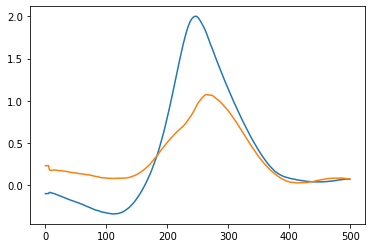

In [113]:
plt.plot(mean_traces[77,:])
plt.plot(mean_traces[77+250,:])

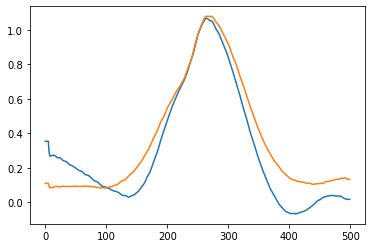

In [109]:
plt.plot(filters[77,2,::-1])
plt.plot(filters[77+250,1,::-1])

In [110]:
mean_traces.shape

(250, 500)

In [102]:
filters[:,1,::-1].shape

(501, 500)

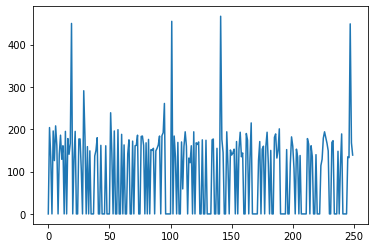

In [101]:
plt.plot(break_points)

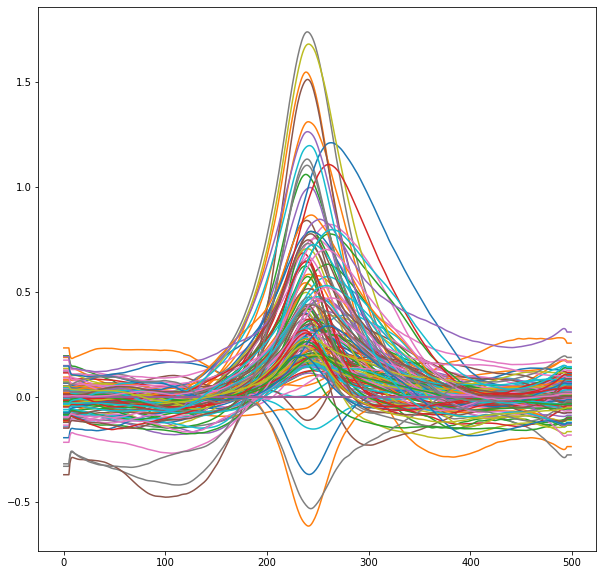

In [91]:
plt.figure(figsize=(10,10))
for i in range(len(mean_traces)):
    plt.plot(mean_traces[i])

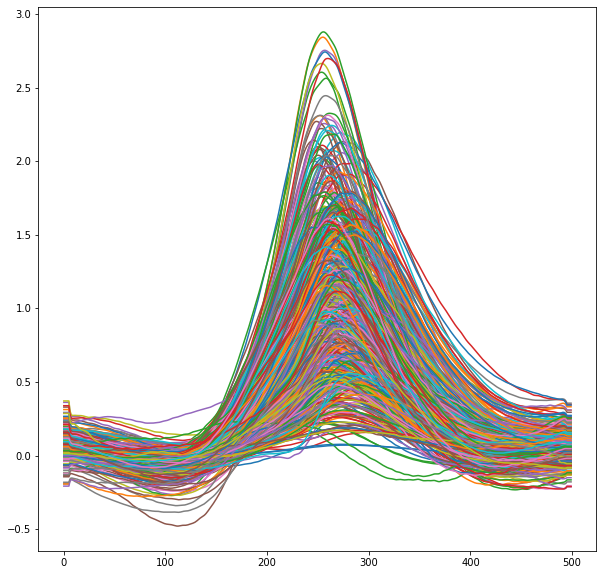

In [117]:
plt.figure(figsize=(10,10))
for i in range(len(mean_traces)):
    plt.plot(mean_traces[i])

In [87]:
np.zeros((500)).shape

(500,)

In [19]:
superthresh_corrs = np.load(os.path.join(cluster_dir,'20230203_superthresh_corrs.npy'))
superthresh_slopes = np.load(os.path.join(cluster_dir,'20230203_superthresh_slopes.npy'))
print(superthresh_corrs.shape, superthresh_slopes.shape)

### average hemis with beh flip
st_corrs = []
st_slopes = []
for cluster_ in range(251):
    ### Ipsi turn
    st_corrs.append((superthresh_corrs[cluster_,1] + superthresh_corrs[cluster_+250,2])/2)
    st_slopes.append((superthresh_slopes[cluster_,1] + superthresh_slopes[cluster_+250,2])/2)
    ### contra turn
    st_corrs.append((superthresh_corrs[cluster_,2] + superthresh_corrs[cluster_+250,1])/2)
    st_slopes.append((superthresh_slopes[cluster_,2] + superthresh_slopes[cluster_+250,1])/2)
    ### Fwd
    st_corrs.append((superthresh_corrs[cluster_,0] + superthresh_corrs[cluster_+250,0])/2)
    st_slopes.append((superthresh_slopes[cluster_,0] + superthresh_slopes[cluster_+250,0])/2)
    
st_corrs = np.reshape(np.asarray(st_corrs),(251,3))
st_slopes = np.reshape(np.asarray(st_slopes),(251,3))
print(st_corrs.shape,st_slopes.shape)

(501, 3) (501, 3)
(251, 3) (251, 3)


In [26]:
colors = np.asarray(break_points).copy().astype('float')
colors[np.where(colors==0)] = np.nan

In [51]:
cmap = matplotlib.cm.get_cmap('jet_r')
cmap.set_bad(color="k")

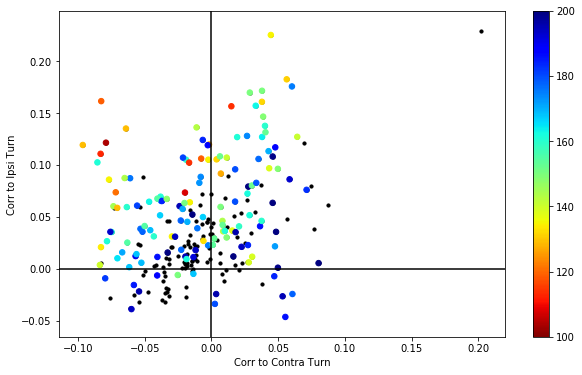

In [52]:
plt.figure(figsize=(10,6))
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.scatter(st_corrs[:250,1],st_corrs[:250,0],color='k',s=10)
plt.scatter(st_corrs[:250,1],st_corrs[:250,0],c=colors,vmin=100,vmax=200,cmap=cmap,s=30)
plt.ylabel('Corr to Ipsi Turn')
plt.xlabel('Corr to Contra Turn')
plt.colorbar()

In [58]:
colors

array([ nan, 204., 135.,  nan, 196., 126., 208., 161.,  nan, 141., 186.,
       129., 161.,  nan, 195.,  nan, 178., 141., 167., 196.,  nan, 129.,
       195.,  nan,  nan, 177., 177., 104.,  nan,  nan, 181.,  nan, 159.,
        nan, 149.,  nan,  nan,  nan, 137., 150., 180.,  nan,  nan, 162.,
        nan,  nan,  nan, 161.,  nan,  nan,  nan, 239., 143.,  nan, 196.,
        nan,  nan, 199.,  nan,  nan, 188.,  nan, 163., 180.,  nan, 142.,
       175.,  nan,  nan, 172.,  nan, 161., 162., 186.,  nan,  nan, 183.,
       184., 162.,  nan, 168.,  nan, 176.,  nan, 152., 150., 155.,  nan,
       149., 155., 163., 184.,  nan, 185., 192., 261.,  nan,  nan,  nan,
        nan,  nan, 455., 199., 184., 135.,  nan, 169.,  nan,  nan, 170.,
       195., 160., 194., 160.,  nan, 132., 121., 161.,  nan, 194.,  nan,
       168., 164., 170.,  nan,  nan, 175.,  nan,  nan, 174.,  nan,  nan,
        nan,  nan, 175., 177.,  nan,  nan, 155.,  nan,  nan, 186., 176.,
       145., 184.,  nan, 194., 113.,  nan, 151., 13

Text(0.5, 0, 'Very Late Offset')

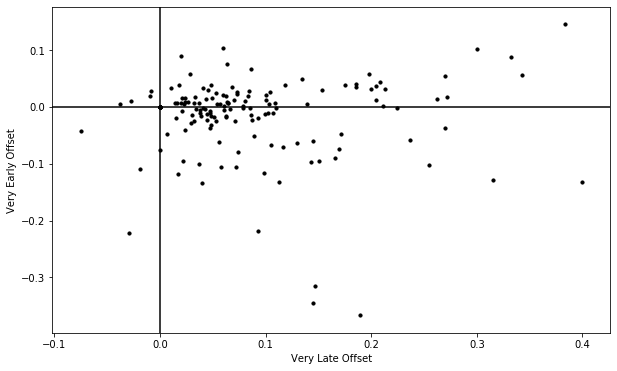

In [85]:
plt.figure(figsize=(10,6))
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.scatter(very_late_clusters,very_early_clusters,color='k',s=10)
plt.ylabel('Very Early Offset')
plt.xlabel('Very Late Offset')

In [ ]:
plt.figure(figsize=(10,6))
plt.axhline(0,color='k')
plt.axvline(250,color='k')
plt.scatter(colors,st_corrs[:250,2],color='k',s=10)
plt.ylabel('Corr to Fwd')
plt.xlabel('Time of Symmetry break')

(array([  1.,   3.,   3., 119.,  26.,  29.,  17.,  14.,   4.,   7.,   6.,
          6.,   3.,   2.,   4.,   1.,   1.,   2.,   0.,   2.]),
 array([-0.0749794 , -0.05124833, -0.02751726, -0.00378618,  0.01994489,
         0.04367596,  0.06740703,  0.0911381 ,  0.11486917,  0.13860024,
         0.16233131,  0.18606238,  0.20979345,  0.23352452,  0.25725559,
         0.28098666,  0.30471773,  0.3284488 ,  0.35217987,  0.37591094,
         0.39964201]),
 <a list of 20 Patch objects>)

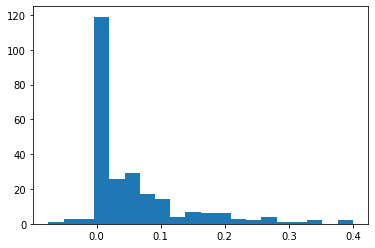

In [70]:
plt.hist(very_late_clusters,bins=20)

In [18]:
very_early_clusters[121]

0.058064533910967935

In [8]:
np.argsort(very_early_clusters)

array([185,  77, 227, 141, 186, 112, 150, 225, 203,  57,  94, 110, 226,
        80, 156,  76, 199, 176, 119, 152, 247, 135, 142,  69, 215,  38,
        18, 229, 182,  62, 101,  85, 162, 189, 163, 249,  88, 233, 175,
       213, 172,  65,  14,  32, 200, 143, 195, 149,  47, 134,  91,  17,
       232, 223, 123, 188, 228, 111, 154,  54,  72,  60,  89, 113,  10,
       239,  78,  73,  90, 126, 181, 218, 220, 221, 148, 145, 222, 230,
       231, 140, 139, 234, 235, 236, 238, 137, 136, 241, 242, 133, 243,
       132, 131, 130, 244, 128, 217, 177, 153, 155, 174, 127, 184, 190,
       171, 191, 192, 193, 170, 194, 169, 168, 167, 164, 196, 197, 202,
       205, 207, 208, 209, 161, 160, 210, 211, 214, 183,   0,  56,  49,
        50,  53,  55, 125,  58,  59,  61,  64,  67,  68,  70,  74,  75,
        79,  48,  46,  45,  44,   3,   8,  13,  15,  20,  23,  24,  81,
        28,  31,  33,  35,  36,  37,  41,  42,  29,  83, 124,  99, 107,
       105, 114,  87,  92, 100, 118, 108,  98,  97,  96, 120, 16

In [207]:
temp = np.asarray(break_points.copy())
temp[np.where(np.asarray(break_points)==0)] = 500

In [206]:
np.asarray(break_points)

array([  0, 204, 135,   0, 196, 126, 208, 161,   0, 141, 186, 129, 161,
         0, 195,   0, 178, 141, 167, 196,   0, 129, 195,   0,   0, 177,
       177, 104,   0,   0, 181,   0, 159,   0, 149,   0,   0,   0, 137,
       150, 180,   0,   0, 162,   0,   0,   0, 161,   0,   0,   0, 239,
       143,   0, 196,   0,   0, 199,   0,   0, 188,   0, 163, 180,   0,
       142, 175,   0,   0, 172,   0, 161, 162, 186,   0,   0, 183, 184,
       162,   0, 168,   0, 176,   0, 152, 150, 155,   0, 149, 155, 163,
       184,   0, 185, 192, 261,   0,   0,   0,   0,   0, 455, 199, 184,
       135,   0, 169,   0,   0, 170, 195, 160, 194, 160,   0, 132, 121,
       161,   0, 194,   0, 168, 164, 170,   0,   0, 175,   0,   0, 174,
         0,   0,   0,   0, 175, 177,   0,   0, 155,   0,   0, 186, 176,
       145, 184,   0, 194, 113,   0, 151, 139, 144, 153,   0, 171,   0,
       154, 193, 135, 144,   0,   0, 190, 174,   0, 131, 215,   0,   0,
         0,   0,   0, 127, 171,   0, 153, 160,   0, 160, 193, 11

In [204]:
np.where(np.asarray(break_points)==0)

(array([  0,   3,   8,  13,  15,  20,  23,  24,  28,  29,  31,  33,  35,
         36,  37,  41,  42,  44,  45,  46,  48,  49,  50,  53,  55,  56,
         58,  59,  61,  64,  67,  68,  70,  74,  75,  79,  81,  83,  87,
         92,  96,  97,  98,  99, 100, 105, 107, 108, 114, 118, 120, 124,
        125, 127, 128, 130, 131, 132, 133, 136, 137, 139, 140, 145, 148,
        153, 155, 160, 161, 164, 167, 168, 169, 170, 171, 174, 177, 181,
        183, 184, 190, 191, 192, 193, 194, 196, 197, 202, 205, 207, 208,
        209, 210, 211, 214, 217, 218, 220, 221, 222, 230, 231, 234, 235,
        236, 238, 241, 242, 243, 244]),)

In [208]:
np.argsort(temp)[::-1]

array([124, 131, 128, 127, 125, 120, 118, 114, 108, 107, 105, 100,  99,
        98,  97,  96,  92, 130, 132,  83, 133, 170, 169, 168, 167, 164,
       161, 160, 155, 153, 148, 145, 140, 139, 137, 136,  87,  81, 174,
        44,  41,  37,  36,  35,  33,  31,  29,  28,  24,  23,  20,  15,
        13,   8,   3,  42,  45,  79,  46,  75,  74,  70,  68,  67,  64,
        61,  59,  58,  56,  55,  53,  50,  49,  48, 171,   0, 211, 221,
       242, 241, 234, 191, 192, 193, 194, 209, 196, 197, 220, 208, 218,
       217, 207, 230, 238, 202, 214, 236, 235, 243, 190, 181, 244, 177,
       231, 183, 222, 184, 205, 210, 101,  95,  51, 166,   6,   1, 189,
        57, 102,  19,   4,  54, 110,  14,  22, 226, 112, 146, 119, 157,
       179,  94, 162, 240, 186,  60, 141,  73,  10,  93,  77, 144, 103,
        91,  76, 199,  30, 185, 227,  63,  40, 225,  16, 212, 247,  26,
       135,  25,  82, 142,  66, 126, 134, 129, 163, 233,  69, 173, 154,
       123, 109, 232, 106,  80, 121, 248, 228,  18, 213, 122,  9

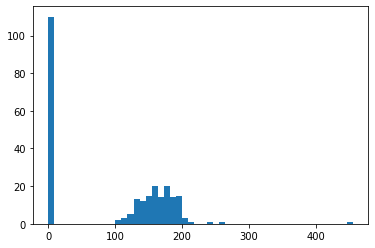

In [176]:
plt.hist(break_points,bins=50);

In [23]:
len(break_points)

250

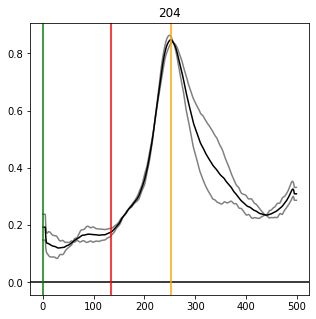

In [239]:
plt.figure(figsize=(5,5))
# use not-normalized
# filter by correlation between two samples
# define sym break by first tp !=0 that is continuous with main hump
bad_SC = [208,234] #234 not bad, but peak diff is at 0

r_thresh = .5
derivative_thresh = 0.001


cluster = 204
flip = False
plt.axhline(0,color='k')

if cluster in bad_SC:
    print("BAD CLUSTER")

a = filters[cluster,1,::-1]-filters[cluster+250,1,::-1]
b = (filters[cluster,2,::-1]-filters[cluster+250,2,::-1])*-1

r,_ = scipy.stats.pearsonr(a,b)

if r < r_thresh:
    print("BAD R")

mean_trace = (a+b)/2

### see if should flip sign for the rare few
extreme_v = mean_trace[np.argmax(np.abs(mean_trace))]
if extreme_v < 0:
    a*=-1; b*=-1; mean_trace*=-1
    flip=True

plt.plot(a,color='grey')
plt.plot(b,color='grey')
plt.plot(mean_trace,color='k')

peak = np.argmax(mean_trace)
plt.axvline(peak,color='orange')

if peak < 10:
    print("BAD PEAK")

# find where derivative exceeds thresh just before peak 
break_div = np.where(np.diff(mean_trace)[:peak][::-1][20:] < derivative_thresh)[0][0] + 20
break_div = peak - break_div

# find where trace exceeds thresh just before peak
above_0 = mean_trace>0.01
try:
    break_0 = np.where(above_0[:peak][::-1] == False)[0][0]
    break_0 = peak - break_0
except IndexError:
    break_0 = 0

# use "latest" of cross 0 and derivative thresh
break_point = np.max(np.asarray((break_div, break_0)))

plt.axvline(break_point,color='r')
plt.axvline(break_0,color='green')
if flip is False:
    plt.title(cluster)
else:
    plt.title(F"{cluster} flip")

In [155]:
np.asarray((break_div, break_0))

array([126,   0])

In [243]:
750*20

15000

In [163]:
### quickly check if any other ROIs other than 77 diverge VERY early
diff_0 = []
for cluster in range(250):
    diff = filters[cluster,1,::-1]-filters[cluster+250,1,::-1]
    diff_0.append(diff[0])

(array([  3.,   7.,  33., 107.,  61.,  25.,   8.,   2.,   3.,   1.]),
 array([-0.3415274 , -0.24540834, -0.14928928, -0.05317021,  0.04294885,
         0.13906791,  0.23518698,  0.33130604,  0.42742511,  0.52354417,
         0.61966323]),
 <a list of 10 Patch objects>)

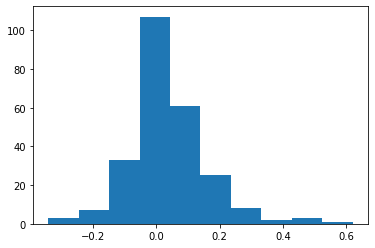

In [164]:
plt.hist(diff_0)

In [165]:
np.argsort(diff_0)

array([185, 192,  77,  69, 227, 186, 150, 176,  38, 226,  80, 112,   0,
       156, 203,  29,  73, 105, 152,  70, 128,  91, 144,  76, 225, 249,
        32, 195, 135, 182, 162,  75, 102, 119, 235, 229, 160,  57, 205,
        24, 199,  67, 163,  63,  74, 143,   4,  59,  88, 166,  78,  13,
        23, 188,  36,  19, 233, 179, 232,  96, 170,  97, 153, 200, 196,
       243,  47,  89, 136, 149, 161, 238, 154, 189,   6, 181,  65, 215,
        94,  34,  62, 159,  90, 111, 191, 117, 123, 134,  18, 208, 101,
       124,  72, 140,  54, 122, 230, 126, 217,   1,   9,  50, 131,  42,
       133,   2, 145, 155,  39, 118,  60, 214, 114,  20,  83, 231, 194,
       184,  46,  41,  49,  51,  14, 236, 113, 103,  16,  48, 210, 108,
       132, 237, 178, 173, 168,  99, 139, 223,  25, 138,  43, 169,  84,
       104, 129,  26, 157,  22,  15, 147, 228,   5,  40, 212, 115, 246,
       187, 142,  98,   7, 109, 247, 248, 219,  45,  30, 213, 201,  52,
       245,   3,  61, 125, 165, 207, 224,  71,  85,  10, 172,  9

# check interesting cluster 77 with indiv flies

In [3]:
### TEMPORAL NEWEST ###
# not based on average supercluster signal, but rather averaged filters from supervoxels
temporal_filters_indiv = []
for fly in range(9):
    file = os.path.join(cluster_dir,"20221128_indiv_temporal_filters", F"fly_{fly}.npy")
    temporal_filters_indiv.append(np.load(file))
temporal_filters_indiv = np.asarray(temporal_filters_indiv)
temporal_filters_indiv = np.swapaxes(temporal_filters_indiv,0,1)
temporal_filters_indiv = np.reshape(temporal_filters_indiv,(501,9,4,500))
print(temporal_filters_indiv.shape)

(501, 9, 4, 500)


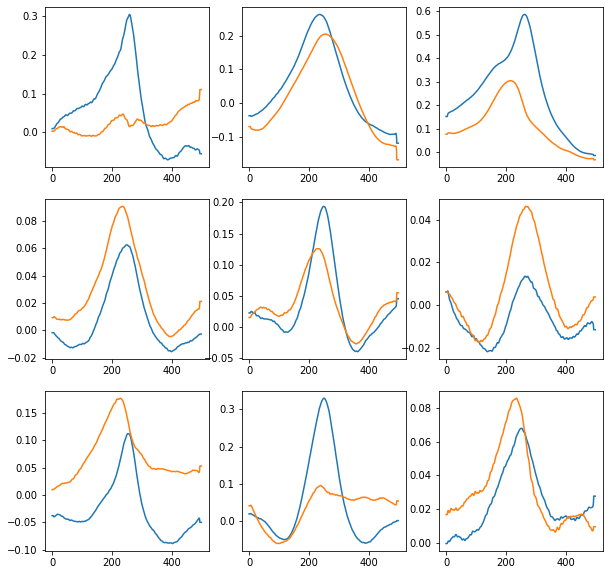

In [6]:
plt.figure(figsize=(10,10))
for fly in range(9):
    plt.subplot(3,3,fly+1)
    plt.plot(temporal_filters_indiv[77,fly,1,:])
    plt.plot(temporal_filters_indiv[77+250,fly,1,:])

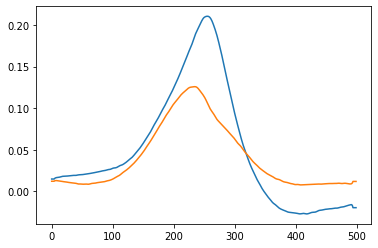

In [9]:
plt.plot(np.mean(temporal_filters_indiv[77,:,1,:],axis=0))
plt.plot(np.mean(temporal_filters_indiv[77+250,:,1,:],axis=0))

# old method

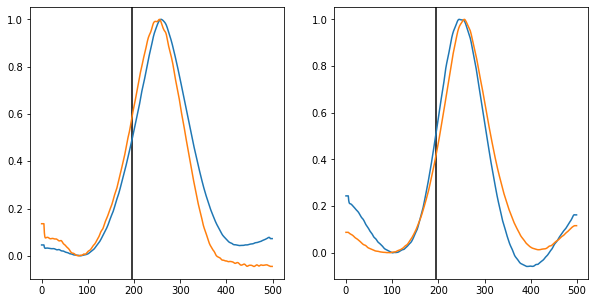

In [65]:
cluster = 150

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axvline(195,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1]))
plt.plot(NormalizeData(filters[cluster+250,1,::-1]))

plt.subplot(122)
plt.axvline(195,color='k')
plt.plot(NormalizeData(filters[cluster,2,::-1]))
plt.plot(NormalizeData(filters[cluster+250,2,::-1]))

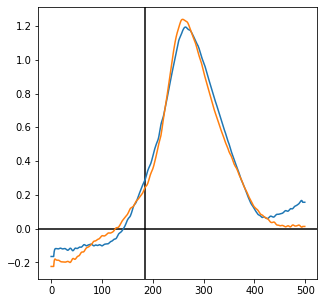

In [34]:
### NOT NORMALIZED ###

cluster = 150

plt.figure(figsize=(5,5))

plt.axhline(0,color='k')
plt.axvline(185,color='k')
plt.plot(filters[cluster,1,::-1]-filters[cluster+250,1,::-1])
plt.plot((filters[cluster,2,::-1]-filters[cluster+250,2,::-1])*-1)

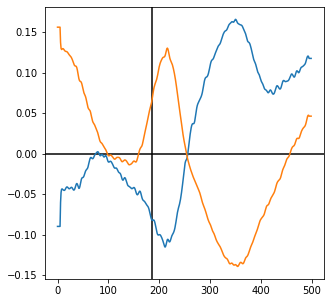

In [35]:
cluster = 150

plt.figure(figsize=(5,5))

plt.axhline(0,color='k')
plt.axvline(185,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1]))
plt.plot((NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1])))

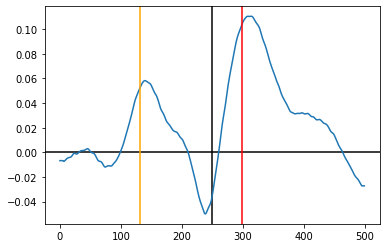

In [162]:
cluster = 51

a = NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1])
b = (NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1]))*-1
difftrace = (a+b)/2
plt.axhline(0,color='k')
plt.axvline(250,color='k')
plt.plot(difftrace)


peak = np.argmax(difftrace[100:300]) + 100
plt.axvline(peak,color='r')
halfmax = np.max(difftrace[100:300])/2

first_past_thresh = np.where(difftrace[100:300]>halfmax)[0][0] + 100

plt.axvline(first_past_thresh,color='orange')

In [153]:
peak

150

In [157]:
max_diff_thresh = 0.1
indiv_thresh = 0.4

sym_break_time = []
for cluster in range(250):

    below = False
    for data in [filters[cluster,1,::-1], filters[cluster+250,1,::-1], filters[cluster,2,::-1], filters[cluster+250,2,::-1]]:
        if np.max(data) < indiv_thresh:
            below = True
    if below is True:
        sym_break_time.append(np.nan)
        continue
    
    
    a = NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1])
    b = (NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1]))*-1
    difftrace = (a+b)/2
    #plt.axhline(0,color='k')
    #plt.axvline(250,color='k')
    #plt.plot(difftrace)

    max_value = np.max(difftrace[150:300])
    if max_value < max_diff_thresh:
        sym_break_time.append(np.nan)
        continue

    peak = np.argmax(difftrace[150:300]) + 150
    #plt.axvline(peak,color='r')
    
    halfmax = max_value/2
    first_past_thresh = np.where(difftrace[150:300]>halfmax)[0][0] + 150
    sym_break_time.append(first_past_thresh)
    
    #plt.axvline(first_past_thresh,color='orange')

In [159]:
np.argsort(sym_break_time)

array([ 51, 234, 102,  36,  24,  78, 158,  20, 200,  97,  96, 132, 143,
       162, 243, 206, 242, 210,  21, 213, 195,   9, 219,  85,  12, 227,
       104, 224, 248, 138, 201,  81, 225,  27, 172,  89, 185, 160,  18,
       198, 165,   5,  11, 147, 157,  77,  17, 151, 175, 111, 149, 233,
        71, 223, 113, 186, 135, 123, 173,  62, 215,  86,   7,  47, 169,
       199,  35,  60, 187,  66, 163,  74,  16, 184, 179, 212, 121,  22,
         6,  82, 110, 141,  95, 156, 144, 205, 161, 178, 177, 159, 150,
       154, 176, 167, 174, 168, 152, 170, 171, 153, 155, 166, 164,   0,
       181, 222, 226, 228, 229, 230, 231, 232, 235, 221, 236, 238, 239,
       240, 241, 244, 245, 246, 247, 237, 220, 218, 217, 182, 183, 188,
       189, 190, 191, 192, 193, 194, 196, 202, 203, 204, 207, 208, 209,
       211, 214, 216, 180, 197, 124, 146,  43,  44,  45,  46,  48,  49,
        50,  52,  53,  54,  55,  56,  57,  58,  59,  61,  63,  64,  65,
        67,  68,  42,  41,  40,  39,   1,   2,   3,   4,   8,  1

(array([ 3.,  0.,  2.,  3., 49., 23.,  0.,  0.,  0.,  6.]),
 array([150. , 162.9, 175.8, 188.7, 201.6, 214.5, 227.4, 240.3, 253.2,
        266.1, 279. ]),
 <a list of 10 Patch objects>)

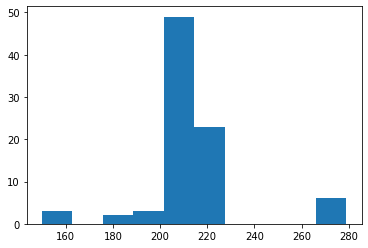

In [158]:
plt.hist(sym_break_time)

In [72]:
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [73]:
### lets visualize these high ipsi low contra on brain
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [74]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in tqdm.tqdm(range(250)):
    ind = np.where(superclusters_250==cluster)
    brain[ind[0],ind[1],ind[2]] = very_late_clusters[cluster]

100%|██████████| 250/250 [00:06<00:00, 37.37it/s]


In [229]:
len(very_early_clusters)

251

In [222]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in very_early_clusters:
    ind = np.where(superclusters_250==cluster)
    brain[ind[0],ind[1],ind[2]] = 1

In [79]:
temporal_map = brain

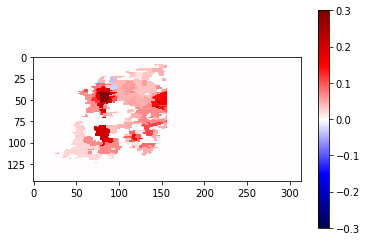

In [75]:
plt.imshow(brain[:,:,60].T,vmin=-.3,vmax=.3,cmap='seismic')
plt.colorbar()

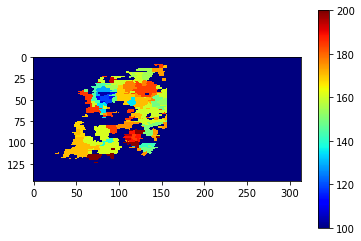

In [180]:
plt.imshow(brain[:,:,60].T,vmin=100,vmax=200,cmap='jet')
plt.colorbar()

In [187]:
temporal_map = 200-brain
temporal_map[np.where(temporal_map==200)] = 0

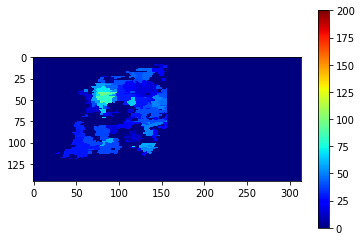

In [188]:
plt.imshow(temporal_map[:,:,60].T,vmin=0,vmax=200,cmap='jet')
plt.colorbar()

In [76]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [77]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [80]:
#input_canvas = np.zeros((500,500,3))
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

# plt.figure(figsize=(10,10))
# plt.imshow(canvas[150:,:],cmap=mymap,vmin=end_c,vmax=start_c)
# plt.axis('off')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# #plt.savefig(fname,dpi=300,bbox_inches='tight')

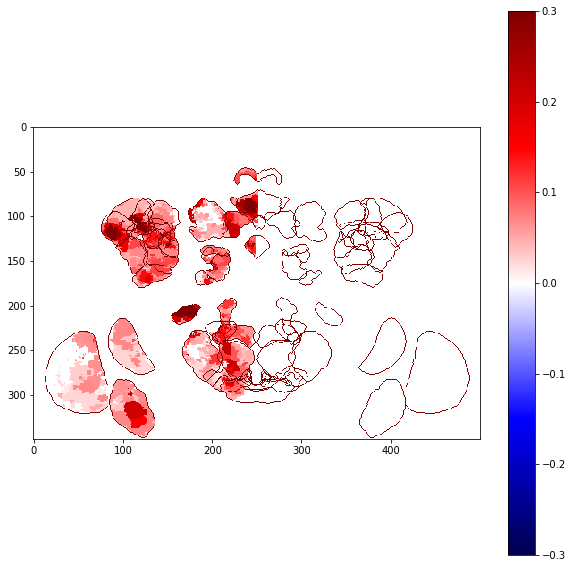

In [81]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],vmin=-.3,vmax=.3,cmap='seismic')
plt.colorbar()

In [7]:
superthresh_corrs = np.load(os.path.join(cluster_dir,'20230203_superthresh_corrs.npy'))
superthresh_slopes = np.load(os.path.join(cluster_dir,'20230203_superthresh_slopes.npy'))
print(superthresh_corrs.shape, superthresh_slopes.shape)

### average hemis with beh flip
st_corrs = []
st_slopes = []
for cluster_ in range(251):
    ### Ipsi turn
    st_corrs.append((superthresh_corrs[cluster_,1] + superthresh_corrs[cluster_+250,2])/2)
    st_slopes.append((superthresh_slopes[cluster_,1] + superthresh_slopes[cluster_+250,2])/2)
    ### contra turn
    st_corrs.append((superthresh_corrs[cluster_,2] + superthresh_corrs[cluster_+250,1])/2)
    st_slopes.append((superthresh_slopes[cluster_,2] + superthresh_slopes[cluster_+250,1])/2)
    ### Fwd
    st_corrs.append((superthresh_corrs[cluster_,0] + superthresh_corrs[cluster_+250,0])/2)
    st_slopes.append((superthresh_slopes[cluster_,0] + superthresh_slopes[cluster_+250,0])/2)
    
st_corrs = np.reshape(np.asarray(st_corrs),(251,3))
st_slopes = np.reshape(np.asarray(st_slopes),(251,3))
print(st_corrs.shape,st_slopes.shape)

(501, 3) (501, 3)
(251, 3) (251, 3)


In [92]:
mean_traces = np.asarray(mean_traces)
mean_traces.shape

(250, 500)

In [114]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20230221_movieb'
os.mkdir(save_path)

In [119]:
for k,tp in enumerate(tqdm.tqdm(range(0,500,10))):

    ### color brain by peak time
    brain = np.zeros((314, 146, 91))
    for cluster in range(500):
        ind = np.where(superclusters_250==cluster)
        brain[ind[0],ind[1],ind[2]] = mean_traces[cluster,tp]

    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = brain
    vmax = 2
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(explosion_map[150:,:])
    plt.axis('off')
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    fig.clf()

100%|██████████| 50/50 [11:42<00:00, 14.04s/it]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

(-0.5, 499.5, 349.5, -0.5)

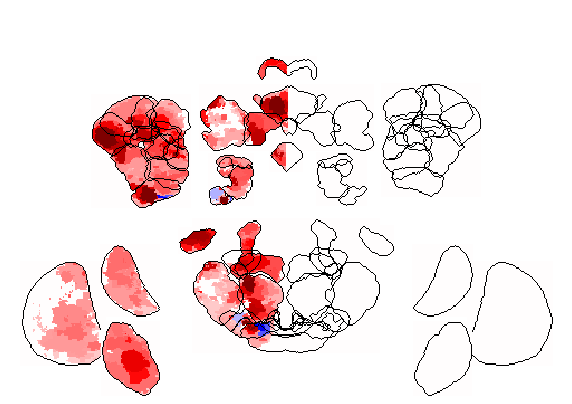

In [ ]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = brain
vmax = .1
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                    diverging=False)#'hot'